#American Sign Language Interpreter


---

#Introduction 
This is an American Sign Language Interpreter, that takes in an image of an ASL gesture, and returns the letter that it corresponds to. To accomplish this, the Sign Language MNIST database (hosted here: https://www.kaggle.com/datasets/datamunge/sign-language-mnist) is used.

#Imports

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.1 MB/s 


In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import keras.backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization, DepthwiseConv2D, GlobalAvgPool2D, LayerNormalization, MaxPool2D

from sklearn.metrics import classification_report,confusion_matrix

#Loading Data

In [ ]:
#loading dataset, assigning variables
#using the following dataset: https://www.kaggle.com/datasets/datamunge/sign-language-mnist
test_dataset = pd.read_csv('sign_mnist_test.csv')
train_dataset = pd.read_csv('sign_mnist_train.csv')

test_label = np.array(test_dataset['label'])
train_label = np.array(train_dataset['label'])
test_data = np.array(test_dataset.drop(columns='label'))
train_data = np.array(train_dataset.drop(columns='label'))

#Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential(
  tf.keras.layers.RandomFlip("horizontal")
)

#Manipulating Data

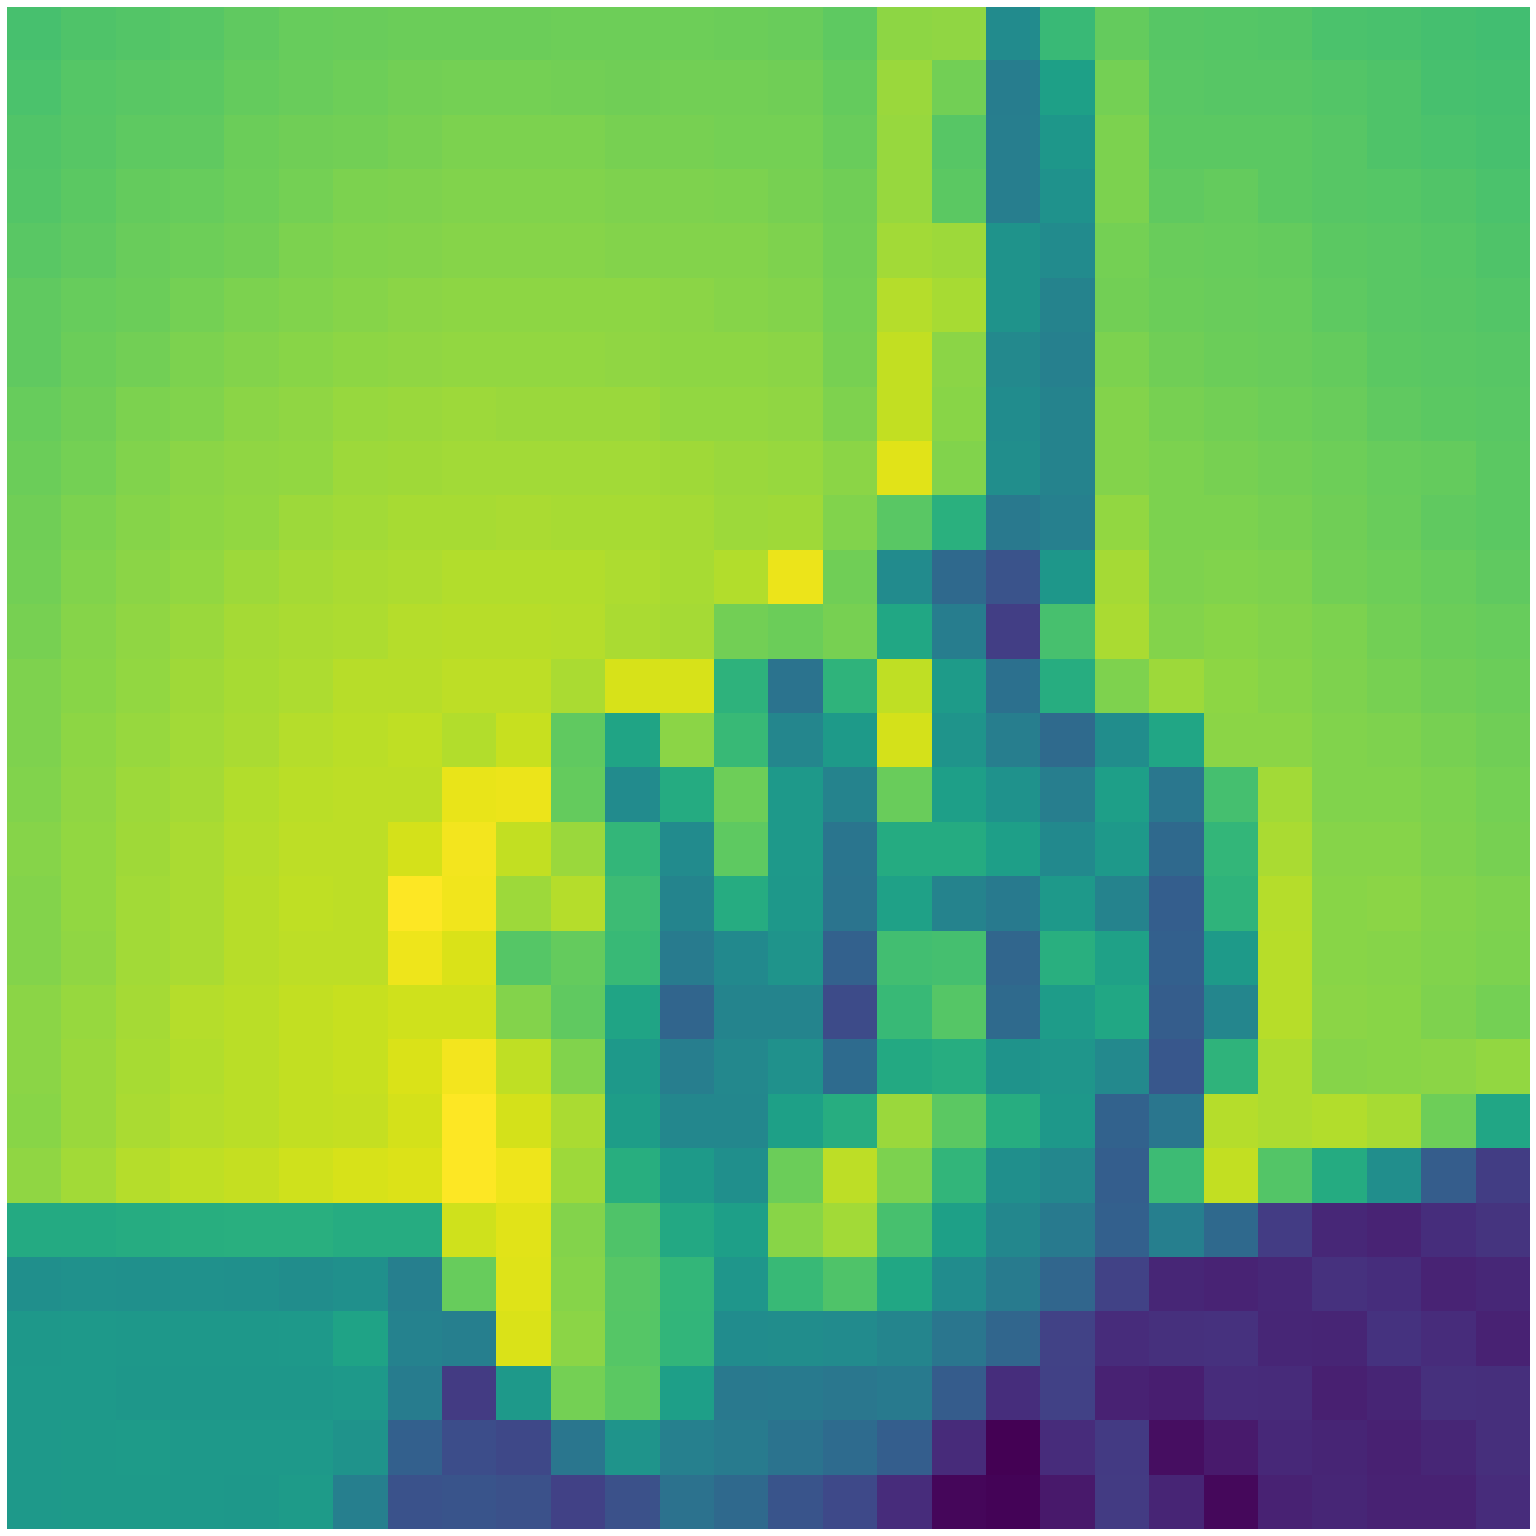

In [ ]:
#reshaping row of pixel values to a 28x28 matrix
test_data = test_data.reshape(test_data.shape[0], 28, 28, 1)
train_data = train_data.reshape(train_data.shape[0], 28, 28, 1)

#converting image to grayscale
test_data = test_data.astype('float32')
train_data = train_data.astype('float32')

#perform grayscale normalization
test_data /= 255.0
train_data /= 255.0

#method to demonstrate what a single image looks like
def show_img():
  some_img = test_data[4].reshape(28,28)
  plt.figure(figsize=(28,28))
  plt.imshow(some_img)
  plt.axis("off")
  plt.show()  

show_img()

In [ ]:
from sklearn.preprocessing import LabelBinarizer
encode = LabelBinarizer()
train_label = encode.fit_transform(train_label)
test_label = encode.fit_transform(test_label)



#Base Model

In [ ]:
model = Sequential()
model.add(data_augmentation)
model.add(Conv2D(50, kernel_size=(3,3), input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(Dense(56, activation=tf.nn.relu))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(25, kernel_size=(3,3), input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dense(256, activation=tf.nn.relu))
model.add(Flatten())
model.add(Dense(24, activation=tf.nn.softmax))

Training and Testing Model

In [ ]:
#Source: https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
#do not compile before all the data is loaded in
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.01), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1_score])

history = model.fit(x=train_data, y=train_label, epochs=7, batch_size=64)
model.summary()

Epoch 1/7
429/429 [==============================] - 54s 123ms/step - loss: 0.4771 - accuracy: 0.8677 - f1_score: 0.8583
Epoch 2/7
429/429 [==============================] - 52s 122ms/step - loss: 0.0538 - accuracy: 0.9845 - f1_score: 0.9847
Epoch 3/7
429/429 [==============================] - 53s 123ms/step - loss: 0.0167 - accuracy: 0.9951 - f1_score: 0.9951
Epoch 4/7
429/429 [==============================] - 53s 122ms/step - loss: 0.0520 - accuracy: 0.9851 - f1_score: 0.9853
Epoch 5/7
429/429 [==============================] - 53s 123ms/step - loss: 0.0407 - accuracy: 0.9907 - f1_score: 0.9908
Epoch 6/7
429/429 [==============================] - 52s 122ms/step - loss: 0.0106 - accuracy: 0.9975 - f1_score: 0.9975
Epoch 7/7
429/429 [==============================] - 52s 122ms/step - loss: 1.5838e-04 - accuracy: 1.0000 - f1_score: 1.0000
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param 

In [ ]:
model.evaluate(test_data, test_label)

225/225 [==============================] - 5s 19ms/step - loss: 0.6348 - accuracy: 0.9127 - f1_score: 0.9131


[0.6348412036895752, 0.9127160906791687, 0.9131073951721191]

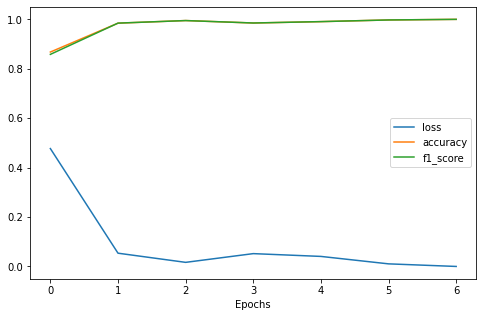

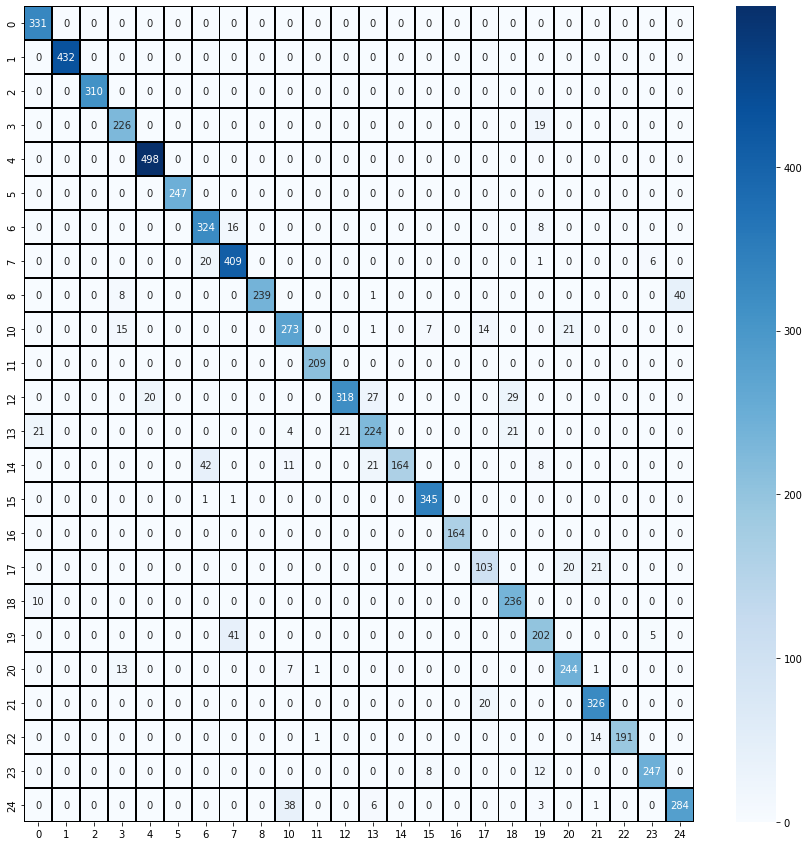

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.xlabel("Epochs")
plt.show()
predictions = model.predict(test_data)
predictions = np.argmax(predictions, axis=1)
test_label_argmaxed = np.argmax(test_label, axis=1)
classes = ["Class " + str(i) for i in range(25) if i != 9]
cm = confusion_matrix(test_label_argmaxed, predictions)
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

#ConvMixer

In [ ]:
def convmixer_model():
  input = keras.Input((28,28,1))
  input = data_augmentation(input)
  #dividing the input image into patches
  patches = Conv2D(20, kernel_size=(3, 3), strides = 3, input_shape=(28,28,1))(input)
  gelu1 = tfa.layers.GELU()(patches)
  batchnorm1 = BatchNormalization()(gelu1)
  #dummy variable to facilitate skip connections during convmix iterations
  batchnorm_dummy = batchnorm1

  #convmix layers with depth of 8
  for i in range(8):
    #depthwise convolution
    depthconv1 = DepthwiseConv2D(kernel_size=(3,3), padding="same")(batchnorm1)
    gelu2 = tfa.layers.GELU()(depthconv1)
    batchnorm2 = BatchNormalization()(gelu2)

    skipconnection = keras.layers.add([batchnorm2, batchnorm_dummy])

    #pointwise convolution
    conv1 = Conv2D(20, kernel_size=(3,3), padding="same")(skipconnection)
    gelu3 = tfa.layers.GELU()(conv1)
    batchnorm3 = BatchNormalization()(gelu3)

    batchnorm_dummy = batchnorm3

  averagelayer = GlobalAvgPool2D()(batchnorm3)
  flatten = Flatten()(averagelayer)
  output = Dense(24, activation=tf.nn.softmax)(flatten)
  model = keras.Model(input, output)
  return model

model = convmixer_model()

Training and Testing Model

In [ ]:
#do not compile before all the data is loaded in
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.01), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1_score])

history = model.fit(x=train_data, y=train_label, epochs=4, batch_size=64)
model.summary()

Epoch 1/4
429/429 [==============================] - 115s 141ms/step - loss: 0.5581 - accuracy: 0.8385 - f1_score: 0.7887
Epoch 2/4
429/429 [==============================] - 59s 136ms/step - loss: 0.0402 - accuracy: 0.9900 - f1_score: 0.9899
Epoch 3/4
429/429 [==============================] - 59s 137ms/step - loss: 0.0018 - accuracy: 0.9999 - f1_score: 0.9999
Epoch 4/4
429/429 [==============================] - 58s 136ms/step - loss: 3.4228e-04 - accuracy: 1.0000 - f1_score: 1.0000
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 9, 9, 20)     200         ['input_2[0][0]']                
 

In [ ]:
model.evaluate(test_data, test_label)

225/225 [==============================] - 6s 24ms/step - loss: 0.0956 - accuracy: 0.9732 - f1_score: 0.9742


[0.09555467218160629, 0.9732292294502258, 0.9742319583892822]

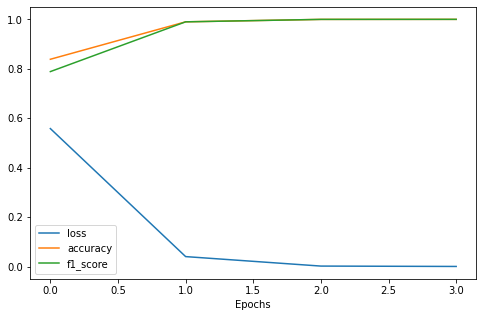

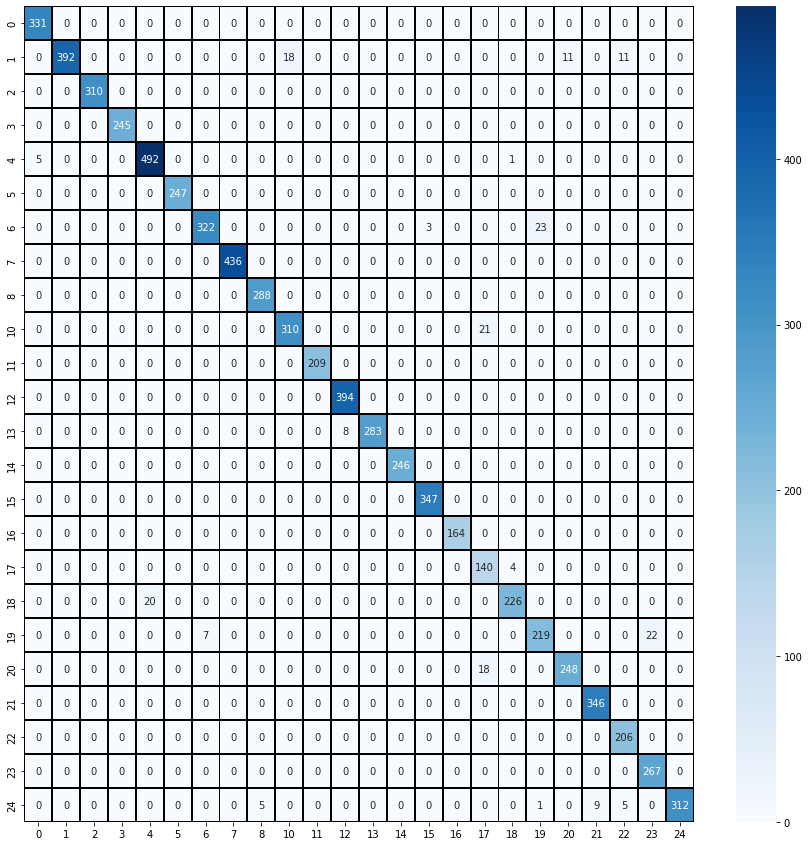

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.xlabel("Epochs")
plt.show()
predictions = model.predict(test_data)
predictions = np.argmax(predictions, axis=1)
test_label_argmaxed = np.argmax(test_label, axis=1)
classes = ["Class " + str(i) for i in range(25) if i != 9]
cm = confusion_matrix(test_label_argmaxed, predictions)
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

#FNet Model

In [ ]:
def fnet_model():
  input = keras.Input((28,28,1))
  input = data_augmentation(input)
  patches = tf.image.extract_patches(
      images = input,
      sizes = [1,3,3,1],
      strides = [1,3,3,1],
      rates=[1,1,1,1],
      padding="VALID"
  )

  patches = tf.reshape(patches, [tf.shape(input)[0], 81, patches.shape[-1]])
 
  layer0 = Dense(15)(patches)

  #performs 2-dimensional fourier transform
  fourier_transform = tf.cast(tf.signal.fft2d(tf.cast(layer0, dtype=tf.dtypes.complex64)), dtype=tf.dtypes.float32)
  skip_connection_1 = keras.layers.add([fourier_transform, layer0])
  layer_normalization = keras.layers.LayerNormalization(epsilon=1e-6)(skip_connection_1)

  #can be customized
  layer1 = Dense(15)(layer_normalization)
  gelu1 = tfa.layers.GELU()(layer1)
  dropout = keras.layers.Dropout(rate=0.2)(gelu1)
  #layer2 = Dense(15)(dropout)
  
  
  skip_connection_2 = keras.layers.add([dropout, layer_normalization])
  
  layer_norm_2 = keras.layers.LayerNormalization(epsilon=1e-6)(skip_connection_2)

  avgpool = keras.layers.GlobalAveragePooling1D()(layer_norm_2)
  #dropout_2 = keras.layers.Dropout(rate=0.2)(avgpool)
  output = Dense(24, activation=tf.nn.softmax)(avgpool)

  model = keras.Model(input, output)
  return model

model = fnet_model()

Training and Testing Model

In [ ]:
#do not compile before all the data is loaded in
model.compile(optimizer= keras.optimizers.Adam(learning_rate=0.01), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1_score])

history = model.fit(x=train_data, y=train_label, epochs=10, batch_size=64)
model.summary()

Epoch 1/10
429/429 [==============================] - 92s 205ms/step - loss: 2.6813 - accuracy: 0.1779 - f1_score: 0.0216
Epoch 2/10
429/429 [==============================] - 86s 201ms/step - loss: 2.3020 - accuracy: 0.2806 - f1_score: 0.0991
Epoch 3/10
429/429 [==============================] - 87s 202ms/step - loss: 2.1495 - accuracy: 0.3194 - f1_score: 0.1429
Epoch 4/10
429/429 [==============================] - 86s 200ms/step - loss: 2.0725 - accuracy: 0.3374 - f1_score: 0.1752
Epoch 5/10
429/429 [==============================] - 85s 199ms/step - loss: 2.0238 - accuracy: 0.3444 - f1_score: 0.1899
Epoch 6/10
429/429 [==============================] - 85s 198ms/step - loss: 1.9822 - accuracy: 0.3608 - f1_score: 0.2069
Epoch 7/10
429/429 [==============================] - 85s 198ms/step - loss: 1.9451 - accuracy: 0.3653 - f1_score: 0.2236
Epoch 8/10
429/429 [==============================] - 85s 198ms/step - loss: 1.9293 - accuracy: 0.3727 - f1_score: 0.2307
Epoch 9/10
429/429 [====

In [ ]:
model.evaluate(test_data, test_label)

225/225 [==============================] - 13s 53ms/step - loss: 2.1660 - accuracy: 0.3100 - f1_score: 0.2282


[2.1659858226776123, 0.3099553883075714, 0.22816164791584015]

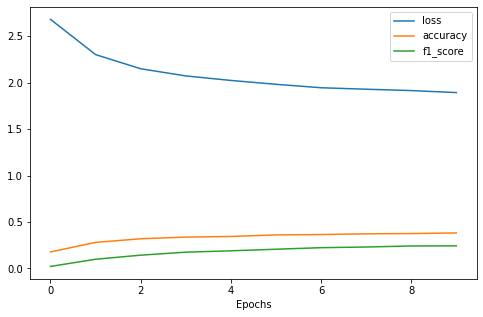

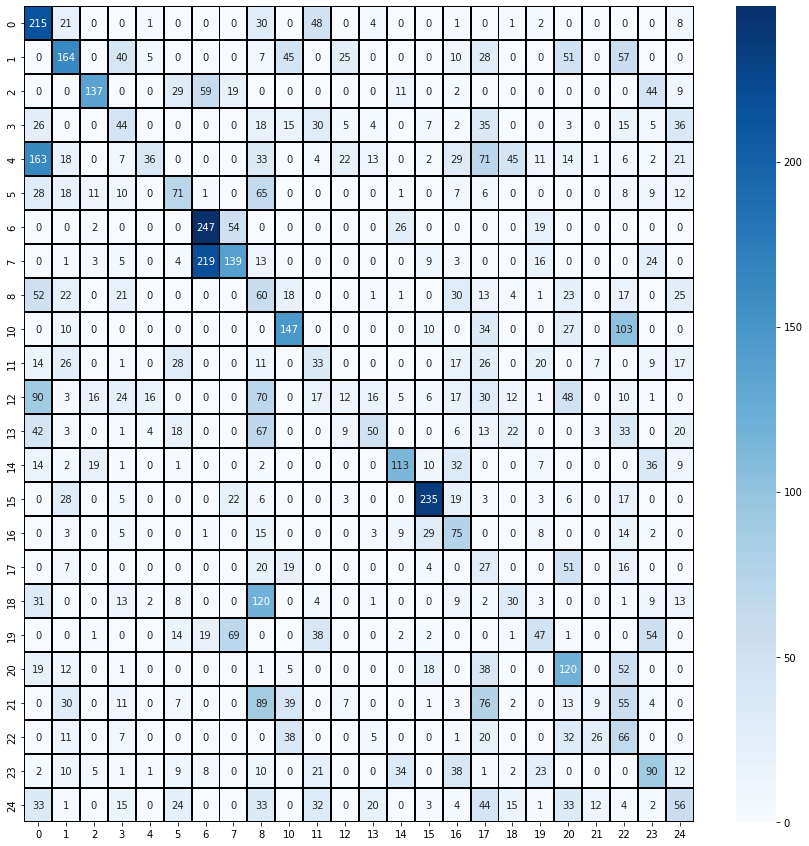

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.xlabel("Epochs")
plt.show()
predictions = model.predict(test_data)
predictions = np.argmax(predictions, axis=1)
test_label_argmaxed = np.argmax(test_label, axis=1)
classes = ["Class " + str(i) for i in range(25) if i != 9]
cm = confusion_matrix(test_label_argmaxed, predictions)
cm = pd.DataFrame(cm , index = [i for i in range(25) if i != 9] , columns = [i for i in range(25) if i != 9])
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')